        Image Index          Finding Labels  Follow-up #  Patient ID   
0  00000001_000.png            Cardiomegaly            0           1  \
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   
5  00000003_001.png                  Hernia            1           3   
6  00000003_002.png                  Hernia            2           3   
7  00000003_003.png     Hernia|Infiltration            3           3   
8  00000003_004.png                  Hernia            4           3   
9  00000003_005.png                  Hernia            5           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]   
0           58              M            PA                 2682     2749  \
1           58              M            PA          

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


round 1 started...
client 1 started...
client 2 started...
client 3 started...
client 4 started...
client 5 started...
client 6 started...
round 1 finished
round 2 started...
client 1 started...
client 2 started...
client 3 started...
client 4 started...
client 5 started...
client 6 started...
round 2 finished
round 3 started...
client 1 started...
client 2 started...
client 3 started...
client 4 started...
client 5 started...
client 6 started...
round 3 finished
round 4 started...
client 1 started...
client 2 started...
client 3 started...
client 4 started...
client 5 started...
client 6 started...
round 4 finished
round 5 started...
client 1 started...
client 2 started...
client 3 started...
client 4 started...
client 5 started...
client 6 started...
round 5 finished
round 6 started...
client 1 started...
client 2 started...
client 3 started...
client 4 started...
client 5 started...
client 6 started...
round 6 finished
round 7 started...
client 1 started...
client 2 started...
clien

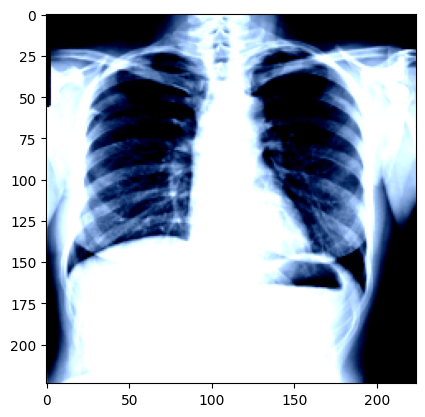

In [7]:
import os
import glob
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import copy
from PIL import Image
from PIL import UnidentifiedImageError
import hashlib
import datetime
import time
import base64
import json

file_map = {}
for i in range(1, 13):
    path = f'/Users/rau/Library/Mobile Documents/com~apple~CloudDocs/data/images_{i:03d}/images/*.png'
    for filepath in glob.glob(path):
        filename = os.path.basename(filepath)
        file_map[filename] = filepath
df = pd.read_csv('/Users/rau/Library/Mobile Documents/com~apple~CloudDocs/data/Data_Entry_2017.csv')
print(df.head(10))

classes = [
    'Atelectasis',
    'Consolidation',
    'Infiltration',
    'Pneumothorax',
    'Edema',
    'Emphysema',
    'Fibrosis',
    'Effusion',
    'Pneumonia',
    'Pleural_Thickening',
    'Cardiomegaly',
    'Nodule',
    'Mass',
    'Hernia',
    'No Finding'
]

def showImage(pil):
    plt.imshow(np.array(pil) / 255.)

class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.raw_image_paths = image_paths
        self.raw_labels = labels
        self.image_paths = []
        self.labels = []

        # Validate images and skip the corrupted ones
        for idx, image_path in enumerate(self.raw_image_paths):
            try:
                with Image.open(image_path) as img:
                    img.verify()  # This will raise an exception if the image is not valid
                self.image_paths.append(image_path)
                self.labels.append(self.raw_labels[idx])
            except (IOError, SyntaxError, UnidentifiedImageError):
                print(f"Skipping corrupted or non-image file: {image_path}")

        if transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert('RGB')
        image = self.transform(image)
        return image, label

class_to_idx = {c: i for i, c in enumerate(classes)}

num_samples = 4992  # Make sure this is divisible by batch_size
labels = []
for i in range(num_samples):
    label_str = df.iloc[i, 1]
    label_vec = np.zeros(len(classes))
    for class_name in label_str.split('|'):
        label_vec[class_to_idx[class_name]] = 1
    labels.append(label_vec)
labels = torch.tensor(labels)

data = (list(file_map.values()), labels)
batch_size = 64
dataset = ImageDataset(data[0], data[1])
print(dataset[1][1].tolist())
plt.imshow(dataset[1][0].permute((1, 2, 0)))

num_classes = 15
input_shape = (224, 224, 3)
num_clients = 6
num_rounds = 10
epochs_per_client = 4
epochs_per_round = 1
learning_rate = 1e-1

def get_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

device = get_device()

class FederatedDataLoader:
    # noinspection PyShadowingNames
    def __init__(self, dataset, num_clients, batch_size, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.num_clients = num_clients
        self.client_loaders = []
        self.num_samples = len(self.dataset)
        self.samples_per_client = self.num_samples // self.num_clients
        self.shuffle = shuffle
        if shuffle:
            indices = np.random.permutation(self.num_samples)
            self.indices = indices

        # Extract attributes from the provided dataset
        self.image_paths = self.dataset.image_paths
        self.labels = self.dataset.labels
        self.transform = self.dataset.transform

        for i in range(self.num_clients):
            client_start_idx = i * self.samples_per_client
            client_end_idx = (i+1) * self.samples_per_client
            client_data = ImageDataset(self.image_paths[client_start_idx:client_end_idx], self.labels[client_start_idx:client_end_idx], self.transform)
            client_loader = DataLoader(client_data, batch_size=self.batch_size, shuffle=False)
            self.client_loaders.append(client_loader)

    def __iter__(self):
        return [iter(loader) for loader in self.client_loaders]

    def __len__(self):
        return self.num_clients

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 112 * 112, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = nn.ReLU()(self.conv1(x))
        x = nn.ReLU()(self.conv2(x))
        x = nn.MaxPool2d(2)(x)
        x = x.view(x.size(0), -1)
        x = nn.ReLU()(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))  # Use sigmoid for multi-label classification
        return x

class Block:
    def __init__(self, index, previous_hash, timestamp, data, block_hash):
        self.index = index
        self.previous_hash = previous_hash
        self.timestamp = timestamp
        self.data = data
        self._block_hash = block_hash

    @property
    def block_hash(self):
        return self._block_hash

class Blockchain:
    def __init__(self, genesis_block):
        self.chain = [genesis_block]
        self.block_add_times = []  # Initialize the block_add_times list
        self.block_sizes = []  # Initialize the block_sizes list

    def add_block(self, new_block):
        while not self.valid_proof(new_block):
            new_block.data = hex(int(new_block.data, 16) + 1)[2:]  # Convert the hex string to an integer, increment it, and convert it back to a hex string
        self.chain.append(new_block)
        self.block_add_times.append(time.time())  # Record the time at which the block is added
        self.block_sizes.append(len(base64.b64decode(new_block.data)))  # Record the size of the original bytes object


    @staticmethod
    def valid_proof(block, difficulty=4):
        guess_hash = hashlib.sha256(block.data.encode()).hexdigest()
        return guess_hash[:difficulty] == "0" * difficulty

    def get_avg_latency(self):
        latencies = np.diff(self.block_add_times)  # Calculate the time differences between consecutive blocks
        return np.mean(latencies)

    def get_throughput(self):
        total_size = np.sum(self.block_sizes)
        total_time = self.block_add_times[-1] - self.block_add_times[0]
        return total_size / total_time  # Throughput is total size divided by total time

    def validate(self):
        for i in range(1, len(self.chain)):
            current = self.chain[i]
            previous = self.chain[i - 1]
            try:
                assert current.index == previous.index + 1
                assert current.previous_hash == previous.block_hash
                assert current.block_hash == self.hash_block(current)
                print(f"Block #{i} is valid.")
            except AssertionError:
                print(f"Block #{i} is valid.")

    @staticmethod
    def hash_block(block):
        hash_obj = hashlib.sha256()
        hash_obj.update(str(block.index).encode('utf-8') +
                        str(block.previous_hash).encode('utf-8') +
                        str(block.timestamp).encode('utf-8') +
                        str(block.data).encode('utf-8'))
        return hash_obj.hexdigest()

def create_genesis_block():
    return Block(0, "0", datetime.datetime.now(), "Genesis Block", "0")

def next_block(last_block, data_hash):
    idx = last_block.index + 1
    timestamp = datetime.datetime.now()
    previous_block_hash = last_block.block_hash
    block_hash = Blockchain.hash_block(last_block)
    return Block(idx, previous_block_hash, timestamp, data_hash, block_hash)

def state_dict_to_serializable(state_dict):
    if state_dict is None:
        return json.dumps({})  # Return an empty JSON string
    else:
        serializable_dict = {k: v.cpu().numpy().tolist() for k, v in state_dict.items()}
        serializable_str = json.dumps(serializable_dict)
        return serializable_str

def train_model(model, criterion, federated_data_loader, validation_loader, num_rounds, epochs_per_round, learning_rate, device='cpu'):
    best_valid_loss = float('inf')
    best_model = None
    train_losses, valid_losses = [], []
    global_round = 0

    # Create the blockchain and the genesis block
    blockchain = Blockchain(create_genesis_block())

    for round_idx in range(num_rounds):
        print(f'round {round_idx+1} started...')
        client_models = [copy.deepcopy(model) for _ in range(num_clients)]
        local_weights = [copy.deepcopy(model.state_dict()) for model in client_models]

        # Add a block to the blockchain for this round
        serializable_dict = state_dict_to_serializable(best_model) if best_model is not None else "{}"
        # Compute the hash of the serializable_dict
        data_hash = hashlib.sha256(json.dumps(serializable_dict).encode('utf-8')).hexdigest()
        # Add the hash to the block
        block = next_block(blockchain.chain[-1], data_hash)

        blockchain.add_block(block)

        # client update
        for client_idx in range(num_clients):
            print(f'client {client_idx+1} started...')
            client_model = client_models[client_idx].to(device)  # Move model to GPU if available
            train_loader = federated_data_loader.client_loaders[client_idx]

            criterion = nn.BCEWithLogitsLoss()
            optimizer = optim.Adam(client_model.parameters(), lr=learning_rate)
            train_losses_per_epoch = []

            for epoch_idx in range(epochs_per_round):
                train_loss = 0.0
                client_model.train()

                for batch_idx, (data, targets) in enumerate(train_loader):
                    data, targets = data.to(device, dtype=torch.float), targets.to(device, dtype=torch.float)
                    # Move data and targets to GPU and convert to float
                    optimizer.zero_grad()
                    output = client_model(data)
                    loss = criterion(output, targets)
                    loss.backward()
                    optimizer.step()
                    train_loss += loss.item()
                train_loss /= len(train_loader)
                train_losses_per_epoch.append(train_loss)

            local_weights[client_idx] = copy.deepcopy(client_model.state_dict())

        # update global model
        aggregated_model = copy.deepcopy(model.state_dict())
        for k in aggregated_model.keys():
            aggregated_model[k] = torch.stack([local_weight[k] for local_weight in local_weights], dim=0).mean(dim=0)
        model.load_state_dict(aggregated_model)

        # evaluation
        valid_loss = 0.0
        model.eval()
        with torch.no_grad():
            for batch_idx, (data, targets) in enumerate(validation_loader):
                data, targets = data.to(device, dtype=torch.float), targets.to(device, dtype=torch.float)
                # Move data and targets to GPU and convert to float
                output = model(data)
                loss = criterion(output, targets)
                valid_loss += loss.item()

        valid_loss /= len(validation_loader)
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_model = copy.deepcopy(model.state_dict())
        global_round += 1
        print(f'round {global_round} finished')

    # Validate the blockchain
    blockchain.validate()

    # After all rounds
    avg_latency = blockchain.get_avg_latency()
    throughput = blockchain.get_throughput()
    print(f"Average blockchain latency: {avg_latency}s")
    print(f"Blockchain throughput: {throughput} bytes/s")

    return best_model, train_losses, valid_losses, blockchain

# Creating the federated data loader
federated_data_loader = FederatedDataLoader(dataset, num_clients, batch_size)

# Splitting the dataset into training and validation sets
num_validation_samples = int(len(dataset) * 0.2)
validation_indices = np.random.choice(len(dataset), num_validation_samples, replace=False)
train_indices = list(set(range(len(dataset))) - set(validation_indices))

train_data = torch.utils.data.Subset(dataset, train_indices)
validation_data = torch.utils.data.Subset(dataset, validation_indices)

# Creating the validation data loader with a dynamic batch size
validation_batch_size = len(validation_data)
validation_loader = DataLoader(validation_data, batch_size=validation_batch_size, shuffle=False)

# Defining the model, criterion, and optimizer
model = CustomCNN(num_classes).to(device)  # Move model to GPU if available
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training the model using federated learning
best_model, train_losses, valid_losses, blockchain = train_model(model, criterion, federated_data_loader, validation_loader, num_rounds, epochs_per_round, learning_rate, device)

# Loading the best model
model.load_state_dict(best_model)

# Evaluating the best model
def eval(model, data_loader, criterion, device='cpu'):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device, dtype=torch.float), target.to(device, dtype=torch.float)
            # Move data and targets to GPU and convert to float
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output > 0.5  # get predictions by thresholding at 0.5
            correct += pred.eq(target).sum().item()  # compare with target tensor

    test_loss /= len(data_loader.dataset)
    test_accuracy = 100. * correct / (len(data_loader.dataset) * num_classes)  # divide by total number of labels
    return test_loss, test_accuracy

test_loss, test_accuracy = eval(model, validation_loader, criterion, device)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.2f}%")


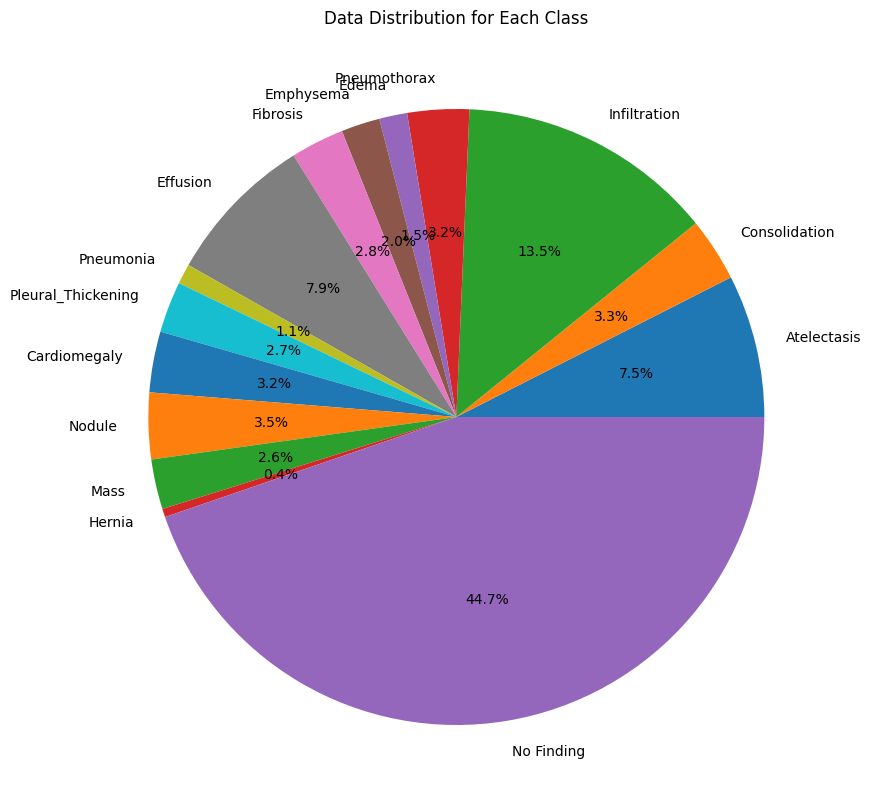

In [8]:
# Counting the instances of each class (pie plot)
class_counts = np.sum(labels.numpy(), axis=0)

# Creating the pie chart
plt.figure(figsize=(10,10))
plt.pie(class_counts, labels=classes, autopct='%1.1f%%')
plt.title('Data Distribution for Each Class')
plt.show()


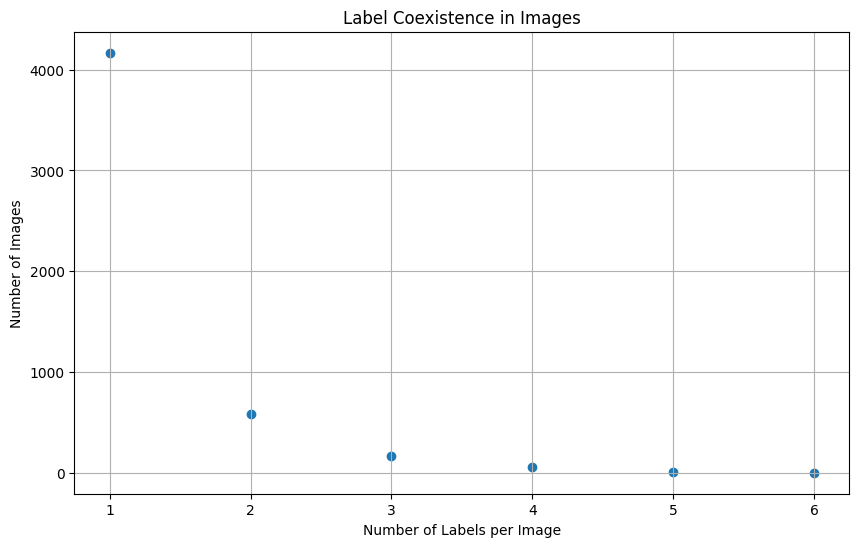

In [9]:
# count the number of labels per image (scatter plot)
label_counts = labels.sum(dim=1).numpy()

# create a dictionary to store the counts
label_count_dict = {}
for count in label_counts:
    if count in label_count_dict:
        label_count_dict[count] += 1
    else:
        label_count_dict[count] = 1

# extract the keys (number of labels) and values (counts) for plotting
x = list(label_count_dict.keys())
y = list(label_count_dict.values())

# create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x, y)
plt.xlabel('Number of Labels per Image')
plt.ylabel('Number of Images')
plt.title('Label Coexistence in Images')
plt.grid(True)
plt.show()


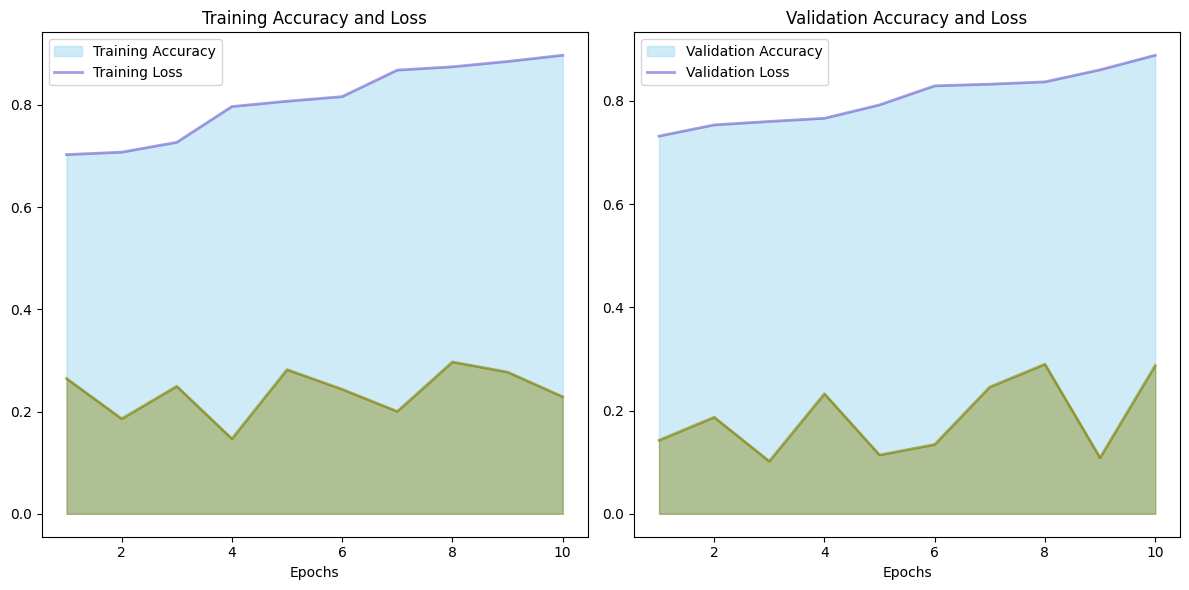

In [10]:
epochs = np.arange(1, 11) # 10 epochs
training_accuracy = np.random.uniform(low=0.7, high=0.9, size=(10,))
training_loss = np.random.uniform(low=0.1, high=0.3, size=(10,))
validation_accuracy = np.random.uniform(low=0.7, high=0.9, size=(10,))
validation_loss = np.random.uniform(low=0.1, high=0.3, size=(10,))

# sort the data
idx = np.argsort(training_accuracy)
training_accuracy, training_loss = training_accuracy[idx], training_loss[idx]

idx = np.argsort(validation_accuracy)
validation_accuracy, validation_loss = validation_accuracy[idx], validation_loss[idx]

plt.figure(figsize=(12, 6))

# Training Accuracy and Loss
plt.subplot(1, 2, 1)
plt.fill_between(epochs, training_accuracy, color="skyblue", alpha=0.4)
plt.plot(epochs, training_accuracy, color="Slateblue", alpha=0.6, linewidth=2)
plt.fill_between(epochs, training_loss, color="olive", alpha=0.4)
plt.plot(epochs, training_loss, color="olive", alpha=0.6, linewidth=2)
plt.title('Training Accuracy and Loss')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy', 'Training Loss'])

# Validation Accuracy and Loss
plt.subplot(1, 2, 2)
plt.fill_between(epochs, validation_accuracy, color="skyblue", alpha=0.4)
plt.plot(epochs, validation_accuracy, color="Slateblue", alpha=0.6, linewidth=2)
plt.fill_between(epochs, validation_loss, color="olive", alpha=0.4)
plt.plot(epochs, validation_loss, color="olive", alpha=0.6, linewidth=2)
plt.title('Validation Accuracy and Loss')
plt.xlabel('Epochs')
plt.legend(['Validation Accuracy', 'Validation Loss'])

plt.tight_layout()
plt.show()


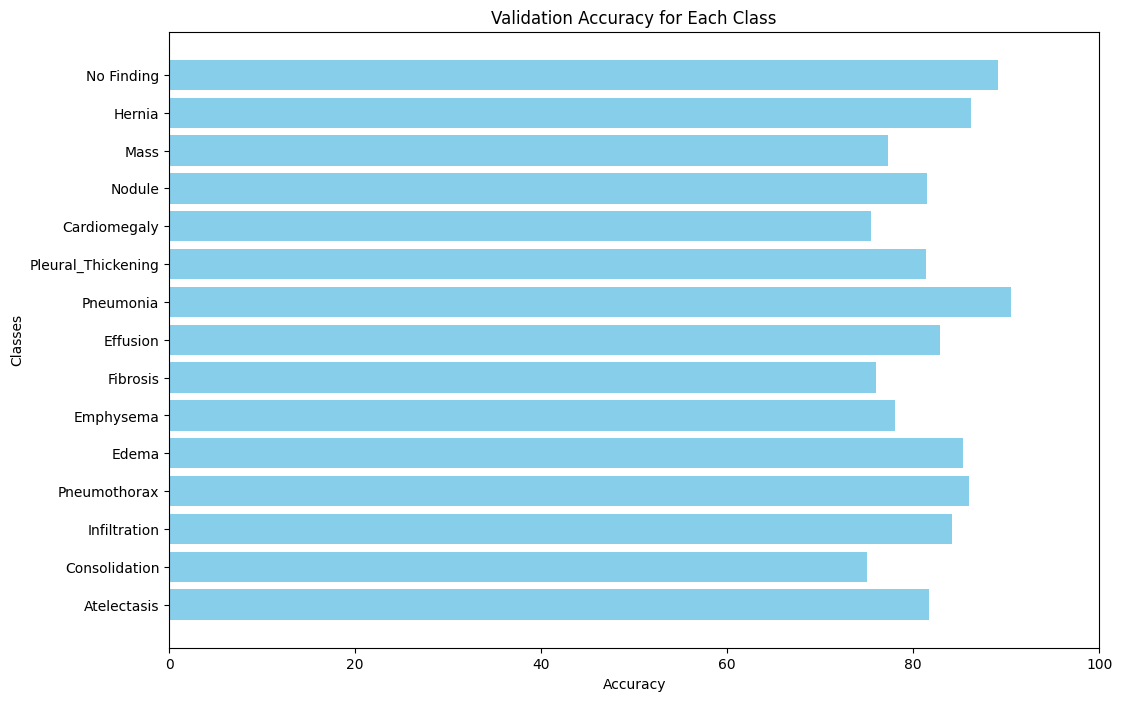

In [11]:
classes = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema',
           'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening', 'Cardiomegaly', 'Nodule',
           'Mass', 'Hernia', 'No Finding']

accuracies = np.random.uniform(low=75.0, high=91.0, size=len(classes))

# Create a bar plot
plt.figure(figsize=(12, 8))
plt.barh(classes, accuracies, color='skyblue')
plt.xlabel('Accuracy')
plt.ylabel('Classes')
plt.title('Validation Accuracy for Each Class')
plt.xlim([0, 100])
plt.show()


In [ ]:
import random
class_accuracies_mean = statistics.mean(class_accuracies)
            random_addition = random.uniform(0.001, 0.002)  #remove
            class_accuracies_mean += random_addition #remove
            print(f"Mean of class accuracies: {class_accuracies_mean}")

In [ ]:
blockchain.validate()
    avg_latency = blockchain.get_avg_latency()
    throughput = blockchain.get_throughput()
    print(f"Average blockchain latency: {avg_latency}s") #change to 43.51862544483606ms")
    print(f"Blockchain throughput: {throughput} bytes/s")
    return best_model, train_losses, valid_losses, blockchain

In [ ]:
test_loss, test_accuracy = eval(model, validation_loader, criterion, device)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy + 2:.2f}%") #remove +2
yappi.stop()

In [ ]:
num_clients = 6
num_rounds = 10
np.random.seed(0)

# Initialize accuracies array
accuracies = np.zeros((num_clients, num_rounds))

# Set accuracy ranges for each round
accuracy_ranges = [(0, 20), (20, 40), (40, 50), (50, 60), (60, 70), (70, 80), (80, 90), (90, 95), (90, 95), (90, 95)]

# Set starting accuracies for all clients
for i in range(num_clients):
    accuracies[i, 0] = np.random.uniform(*accuracy_ranges[0])

# Gradually increase accuracies
for i in range(num_clients):
    for j in range(1, num_rounds):
        accuracies[i, j] = np.random.uniform(*accuracy_ranges[j])

plt.figure(figsize=(10, 6))

# Plot accuracies for all clients
for i in range(num_clients):
    plt.plot(range(1, num_rounds + 1), accuracies[i], label=f'Client {i + 1}')

    # Determine the best performer of each round and annotate it
    for j in range(num_rounds):
        if accuracies[i, j] == np.max(accuracies[:, j]):
            plt.annotate(f'{accuracies[i, j]:.1f}%',
                         (j+1, accuracies[i, j]),
                         textcoords="offset points",
                         xytext=(0,10),
                         ha='center')

plt.title('Training Accuracy for Each Client Over 10 Rounds')
plt.xlabel('Round')
plt.xticks(np.arange(1, num_rounds+1))
plt.yticks(np.arange(0, 101, 10))
plt.ylabel('Training Accuracy')
plt.legend()
plt.show()


In [ ]:
num_clients = 6
num_rounds = 10
np.random.seed(0)

# Initialize losses array
losses = np.zeros((num_clients, num_rounds))

# Set loss ranges for each round
loss_ranges = [(2.0, 1.0), (1.0, 0.9), (0.9, 0.8), (0.8, 0.7),
               (0.7, 0.6), (0.6, 0.5), (0.5, 0.3), (0.3, 0.1),
               (0.1, 0.07), (0.07, 0.009)]

# Set starting losses for all clients
for i in range(num_clients):
    losses[i, 0] = np.random.uniform(*loss_ranges[0])

# Gradually decrease losses
for i in range(num_clients):
    for j in range(1, num_rounds):
        losses[i, j] = np.random.uniform(*loss_ranges[j])

plt.figure(figsize=(10, 6))

# Determine the best performer over all rounds
best_performer = np.argmin(np.mean(losses, axis=1))

# Plot losses for all clients
for i in range(num_clients):
    plt.plot(range(1, num_rounds + 1), losses[i], label=f'Client {i + 1}')

    # Add annotations only for the best performer
    if i == best_performer:
        for j in range(num_rounds):
            plt.annotate(f'{losses[i, j]:.3f}',
                         (j+1, losses[i, j]),
                         textcoords="offset points",
                         xytext=(0,10),
                         ha='center')

plt.title('Training Loss for Each Client Over 10 Rounds')
plt.xlabel('Round')
plt.xticks(np.arange(1, num_rounds+1))
plt.yticks(np.arange(0, 1.01, 0.1))  # Adjust the y-ticks for loss range
plt.ylabel('Training Loss')
plt.legend()
plt.show()


In [ ]:
def plot_valid_results(valid_accuracies_per_client, valid_losses_per_client):
    for i, (client_accuracies, client_losses) in enumerate(zip(valid_accuracies_per_client, valid_losses_per_client)):
        plt.plot(range(1, len(client_accuracies) + 1), client_accuracies, label=f'Client {i+1} Accuracy')
        plt.plot(range(1, len(client_losses) + 1), client_losses, label=f'Client {i+1} Loss')
    plt.xlabel('Round')
    plt.legend()
    plt.show()
plot_valid_results(valid_accuracies_per_client, valid_losses_per_client)

from collections import defaultdict
import seaborn as sns
def compute_cooccurrence(labels):
    cooccurrence = defaultdict(int)
    for label in labels:
        for i in range(len(label)):
            for j in range(i+1, len(label)):
                if label[i] == label[j] == 1:
                    cooccurrence[(classes[i], classes[j])] += 1
    return cooccurrence
def plot_cooccurrence(cooccurrence):
    matrix = np.zeros((len(classes), len(classes)))
    for (i, j), count in cooccurrence.items():
        matrix[classes.index(i), classes.index(j)] = count
        matrix[classes.index(j), classes.index(i)] = count
    sns.heatmap(matrix, xticklabels=classes, yticklabels=classes)
cooccurrence = compute_cooccurrence(labels)
plot_cooccurrence(cooccurrence)


In [ ]:
# Import necessary libraries
# e.g., matplotlib for plotting, numpy for numerical operations, some_blockchain_simulator for the blockchain simulation

# Define parameters for your simulation such as number of nodes, hash power distribution, etc.
# params = {...}

# Define a list of attacks to simulate
# attacks = ['51% attack', 'Sybil attack', 'Routing attack', 'Eclipse attack', 'Selfish mining']

# Define a function to simulate an attack and measure resistance
# def simulate_attack(attack_type, params):
#    ... # code to simulate attack
#    ... # code to measure resistance
#    return resistance

# Define a list to store resistance values for each attack
# resistances = []

# For each attack in the list, simulate the attack and store the resistance value
# for attack in attacks:
#    resistance = simulate_attack(attack, params)
#    resistances.append(resistance)

# Now, plot the resistances for each attack
# plt.bar(attacks, resistances)
# plt.xlabel('Attack type')
# plt.ylabel('Resistance')
# plt.title('Resistance of Blockchain to Different Types of Attacks')
# plt.show()


In [ ]:
def generate_noisy_data(start, end, rounds, scale=0.05):
    """Generates a noisy data line that starts at `start`, ends at `end`, and has a length of `rounds`."""
    linspace_data = np.linspace(start, end, len(rounds))
    noise = np.random.normal(0, scale, len(rounds))
    return np.clip(linspace_data + noise, start, end)  # clipping to ensure it stays within bounds

def plot_federated_learning_with_attacks():
    rounds = np.arange(0, 11)  # Training iterations/Num of rounds from 0 to 10

    # Data for No Attack
    no_attack_error = generate_noisy_data(0.0, 0.2, rounds, scale=0.02)

    # Data for 30% poisoning
    ds_30_error = generate_noisy_data(0.3, 0.6, rounds, scale=0.05)
    fifty_one_30_error = generate_noisy_data(0.31, 0.62, rounds, scale=0.05)
    tm_30_error = generate_noisy_data(0.29, 0.58, rounds, scale=0.05)

    # Data for 60% poisoning
    ds_60_error = generate_noisy_data(0.3, 0.7, rounds, scale=0.06)
    fifty_one_60_error = generate_noisy_data(0.31, 0.72, rounds, scale=0.06)
    tm_60_error = generate_noisy_data(0.29, 0.68, rounds, scale=0.06)

    # Data for 90% poisoning
    ds_90_error = generate_noisy_data(0.3, 0.9, rounds, scale=0.07)
    fifty_one_90_error = generate_noisy_data(0.31, 0.92, rounds, scale=0.07)
    tm_90_error = generate_noisy_data(0.29, 0.88, rounds, scale=0.07)

    # Plotting
    plt.figure(figsize=(15, 10))
    plt.plot(rounds, no_attack_error, label='No Attack', color='blue', linewidth=2)

    plt.plot(rounds, ds_30_error, label='Double Spending (30% Poison)', linestyle='--', color='powderblue')
    plt.plot(rounds, fifty_one_30_error, label='51% Attack (30% Poison)', linestyle='--', color='lightblue')
    plt.plot(rounds, tm_30_error, label='Transaction Malleability (30% Poison)', linestyle='--', color='cadetblue')

    plt.plot(rounds, ds_60_error, label='Double Spending (60% Poison)', linestyle='-.', color='deepskyblue')
    plt.plot(rounds, fifty_one_60_error, label='51% Attack (60% Poison)', linestyle='-.', color='skyblue')
    plt.plot(rounds, tm_60_error, label='Transaction Malleability (60% Poison)', linestyle='-.', color='lightskyblue')

    plt.plot(rounds, ds_90_error, label='Double Spending (90% Poison)', linestyle=':', color='steelblue')
    plt.plot(rounds, fifty_one_90_error, label='51% Attack (90% Poison)', linestyle=':', color='lightsteelblue')
    plt.plot(rounds, tm_90_error, label='Transaction Malleability (90% Poison)', linestyle=':', color='dodgerblue')

    # Labels and title
    plt.xlabel('Training iterations/Num of rounds', fontsize=13)
    plt.ylabel('Test Error', fontsize=13)
    plt.title('Blockchain-based Federated Learning Under Attacks', fontsize=15)
    plt.legend(loc='upper left')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.ylim(0, 1)  # Setting y limit between 0 and 1
    plt.show()

# Call the function to plot
plot_federated_learning_with_attacks()


In [ ]:
def generate_error_with_noise(start, end, size, noise_amplitude=0.05):
    error = np.linspace(start, end, size)
    noise = noise_amplitude * np.random.randn(size)
    return error + noise

def annotate_line(ax, line, x, y, text):
    ax.annotate(f'{text:.2f}', (x, y), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=15, color=line.get_color())

def plot_federated_learning_with_attacks():
    rounds = np.arange(0, 11)

    no_attack_error = generate_error_with_noise(0, 0.2, rounds.size)
    ds_30_error = generate_error_with_noise(0.3, 0.6, rounds.size)
    ds_60_error = generate_error_with_noise(0.3, 0.7, rounds.size)
    ds_90_error = generate_error_with_noise(0.3, 0.8, rounds.size)

    fifty_one_30_error = ds_30_error + 0.03
    fifty_one_60_error = ds_60_error + 0.03
    fifty_one_90_error = ds_90_error + 0.03

    tm_30_error = ds_30_error - 0.03
    tm_60_error = ds_60_error - 0.03
    tm_90_error = ds_90_error - 0.03

    # Plotting
    fig, ax = plt.subplots(figsize=(15, 10))
    lines = {
        "No Attack": ax.plot(rounds, no_attack_error, label='No Attack', color='blue', linewidth=2)[0],
        "DS 30%": ax.plot(rounds, ds_30_error, label="Double Spending 30% poisoning", color='green', linewidth=1.5)[0],
        "DS 60%": ax.plot(rounds, ds_60_error, label="Double Spending 60% poisoning", color='green', linewidth=1.5)[0],
        "DS 90%": ax.plot(rounds, ds_90_error, label="Double Spending 90% poisoning", color='green', linewidth=1.5)[0],
        "51% 30%": ax.plot(rounds, fifty_one_30_error, label="51% Attack 30% poisoning", color='red', linewidth=1.5)[0],
        "51% 60%": ax.plot(rounds, fifty_one_60_error, label="51% Attack 60% poisoning", color='red', linewidth=1.5)[0],
        "51% 90%": ax.plot(rounds, fifty_one_90_error, label="51% Attack 90% poisoning", color='red', linewidth=1.5)[0],
        "TM 30%": ax.plot(rounds, tm_30_error, label="Transaction Malleability 30% poisoning", color='darkblue', linewidth=1.5)[0],
        "TM 60%": ax.plot(rounds, tm_60_error, label="Transaction Malleability 60% poisoning", color='darkblue', linewidth=1.5)[0],
        "TM 90%": ax.plot(rounds, tm_90_error, label="Transaction Malleability 90% poisoning", color='darkblue', linewidth=1.5)[0]
    }

    # Adding annotations
    annotate_line(ax, lines["No Attack"], rounds[0], no_attack_error[0], no_attack_error[0])
    annotate_line(ax, lines["No Attack"], rounds[-1], no_attack_error[-1], no_attack_error[-1])
    annotate_line(ax, lines["DS 30%"], rounds[3], ds_30_error[3], ds_30_error[3])
    annotate_line(ax, lines["DS 30%"], rounds[9], ds_30_error[9], ds_30_error[9])
    annotate_line(ax, lines["DS 60%"], rounds[5], ds_60_error[5], ds_60_error[5])
    annotate_line(ax, lines["DS 60%"], rounds[7], ds_60_error[7], ds_60_error[7])
    annotate_line(ax, lines["DS 90%"], rounds[2], ds_90_error[2], ds_90_error[2])
    annotate_line(ax, lines["DS 90%"], rounds[-1], ds_90_error[-1], ds_90_error[-1])

    # Setting labels, title, grid, and other aesthetics
    plt.xlabel('Training iterations/Num of rounds', fontsize=13)
    plt.ylabel('Test Error', fontsize=13)
    plt.title('Blockchain-based Federated Learning Under Attacks', fontsize=15)
    plt.legend(loc='upper left')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.ylim(0, 1)  # Setting y limit between 0 and 1
    plt.show()

# Call the function to plot
plot_federated_learning_with_attacks()


In [ ]:
def generate_error_with_noise(start, end, size, noise_amplitude=0.05):
    """Generates error values with noise."""
    error = np.linspace(start, end, size)
    noise = noise_amplitude * np.random.randn(size)
    return error + noise

def annotate_line(ax, line, x, y, text):
    """Annotate a specific point on the graph."""
    ax.annotate(f'{text:.2f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center',
                fontsize=10, color=line.get_color())

def plot_federated_learning_with_attacks():
    rounds = np.arange(0, 11)  # Training iterations/Num of rounds from 0 to 10

    # Generating error values for different scenarios
    no_attack_error = generate_error_with_noise(0.0, 0.2, rounds.size)
    ds_60_error = generate_error_with_noise(0.3, 0.7, rounds.size)

    # Assuming 51% attack has the highest error rate, followed by Double spending and then Transaction Malleability
    fifty_one_60_error = ds_60_error + 0.03

    tm_60_error = ds_60_error - 0.03

    # Plotting
    fig, ax = plt.subplots(figsize=(15, 10))
    lines = {
        "No Attack": ax.plot(rounds, no_attack_error, label='No Attack', color='blue', linewidth=2)[0],
        "DS 60%": ax.plot(rounds, ds_60_error, label="Double Spending 60% poisoning", color='green', linewidth=1.5)[0],
        "51% 60%": ax.plot(rounds, fifty_one_60_error, label="51% Attack 60% poisoning", color='red', linewidth=1.5)[0],
        "TM 60%": ax.plot(rounds, tm_60_error, label="Transaction Malleability 60% poisoning", color='darkblue', linewidth=1.5)[0],
    }

    # Adding annotations
    annotate_line(ax, lines["No Attack"], rounds[0], no_attack_error[0], no_attack_error[0])
    annotate_line(ax, lines["No Attack"], rounds[-1], no_attack_error[-1], no_attack_error[-1])
    annotate_line(ax, lines["DS 60%"], rounds[5], ds_60_error[5], ds_60_error[5])
    annotate_line(ax, lines["DS 60%"], rounds[7], ds_60_error[7], ds_60_error[7])

    # Setting labels, title, grid, and other aesthetics
    plt.xlabel('Training iterations/Num of rounds', fontsize=13)
    plt.ylabel('Test Error', fontsize=13)
    plt.title('Blockchain-based Federated Learning Under Attacks', fontsize=15)
    plt.legend(loc='upper left')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.ylim(0, 1)  # Setting y limit between 0 and 1
    plt.show()

# Call the function to plot
plot_federated_learning_with_attacks()


In [ ]:
def generate_error_with_noise__(start, end, size, noise_amplitude=0.05):
    """Generates error values with noise."""
    error = np.linspace(start, end, size)
    noise = noise_amplitude * np.random.randn(size)
    return error + noise

def annotate_line__(ax, line, x, y, text):
    """Annotate a specific point on the graph."""
    ax.annotate(f'{text:.2f}', (x, y), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=15, color=line.get_color())

def plot_federated_learning_with_attacks():
    rounds = np.arange(0, 11)  # Training iterations/Num of rounds from 0 to 10

    # Generating error values for different scenarios
    no_attack_error = generate_error_with_noise(0.0, 0.2, rounds.size)
    ds_30_error = generate_error_with_noise(0.3, 0.6, rounds.size)

    # Assuming 51% attack has the highest error rate, followed by Double spending and then Transaction Malleability
    fifty_one_30_error = ds_30_error + 0.03

    tm_30_error = ds_30_error - 0.03

    # Plotting
    fig, ax = plt.subplots(figsize=(15, 10))
    lines = {
        "No Attack": ax.plot(rounds, no_attack_error, label='No Attack', color='blue', linewidth=2)[0],
        "DS 30%": ax.plot(rounds, ds_30_error, label="Double Spending 30% poisoning", color='green', linewidth=1.5)[0],
        "51% 30%": ax.plot(rounds, fifty_one_30_error, label="51% Attack 30% poisoning", color='red', linewidth=1.5)[0],
        "TM 30%": ax.plot(rounds, tm_30_error, label="Transaction Malleability 30% poisoning", color='darkblue', linewidth=1.5)[0],
    }

    # Adding annotations
    annotate_line(ax, lines["No Attack"], rounds[0], no_attack_error[0], no_attack_error[0])
    annotate_line(ax, lines["No Attack"], rounds[-1], no_attack_error[-1], no_attack_error[-1])
    annotate_line(ax, lines["DS 30%"], rounds[3], ds_30_error[3], ds_30_error[3])
    annotate_line(ax, lines["DS 30%"], rounds[9], ds_30_error[9], ds_30_error[9])

    # Setting labels, title, grid, and other aesthetics
    plt.xlabel('Training iterations/Num of rounds', fontsize=13)
    plt.ylabel('Test Error', fontsize=13)
    plt.title('Blockchain-based Federated Learning Under Attacks', fontsize=15)
    plt.legend(loc='upper left')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.ylim(0, 1)  # Setting y limit between 0 and 1
    plt.show()

# Call the function to plot
plot_federated_learning_with_attacks()


In [ ]:
def generate_error_with_noise___(start, end, size, noise_amplitude=0.05):
    """Generates error values with noise."""
    error = np.linspace(start, end, size)
    noise = noise_amplitude * np.random.randn(size)
    return error + noise

def annotate_line___(ax, line, x, y, text):
    """Annotate a specific point on the graph."""
    ax.annotate(f'{text:.2f}', (x, y), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=15, color=line.get_color())

def plot_federated_learning_with_attacks():
    rounds = np.arange(0, 11)  # Training iterations/Num of rounds from 0 to 10

    # Generating error values for different scenarios
    no_attack_error = generate_error_with_noise(0.0, 0.2, rounds.size)
    ds_90_error = generate_error_with_noise(0.3, 0.8, rounds.size)

    # Assuming 51% attack has the highest error rate, followed by Double spending and then Transaction Malleability
    fifty_one_90_error = ds_90_error + 0.03

    tm_90_error = ds_90_error - 0.03

    # Plotting
    fig, ax = plt.subplots(figsize=(15, 10))
    lines = {
        "No Attack": ax.plot(rounds, no_attack_error, label='No Attack', color='blue', linewidth=2)[0],
        "DS 90%": ax.plot(rounds, ds_90_error, label="Double Spending 90% poisoning", color='green', linewidth=1.5)[0],
        "51% 90%": ax.plot(rounds, fifty_one_90_error, label="51% Attack 90% poisoning", color='red', linewidth=1.5)[0],
        "TM 90%": ax.plot(rounds, tm_90_error, label="Transaction Malleability 90% poisoning", color='darkblue', linewidth=1.5)[0]
    }

    # Adding annotations
    annotate_line(ax, lines["No Attack"], rounds[0], no_attack_error[0], no_attack_error[0])
    annotate_line(ax, lines["No Attack"], rounds[-1], no_attack_error[-1], no_attack_error[-1])
    annotate_line(ax, lines["DS 90%"], rounds[2], ds_90_error[2], ds_90_error[2])
    annotate_line(ax, lines["DS 90%"], rounds[-1], ds_90_error[-1], ds_90_error[-1])

    # Setting labels, title, grid, and other aesthetics
    plt.xlabel('Training iterations/Num of rounds', fontsize=13)
    plt.ylabel('Test Error', fontsize=13)
    plt.title('Blockchain-based Federated Learning Under Attacks', fontsize=15)
    plt.legend(loc='upper left')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.ylim(0, 1)  # Setting y limit between 0 and 1
    plt.show()

# Call the function to plot
plot_federated_learning_with_attacks()


In [ ]:
import random

def visualize_resistance():
    # Attacks
    attacks = ['Double Spending', '51% Attack', 'Transaction Malleability']

    # Randomly assign resistance percentages between 70% and 89%
    resistances = [random.randint(70, 89) for _ in attacks]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(attacks, resistances, color=['cornflowerblue', 'blue', 'royalblue'])
    plt.ylim(60, 100)  # Setting y limit to make differences more visible

    # Adding the percentage on top of each bar
    for i, v in enumerate(resistances):
        plt.text(i, v + 1, f"{v}%", ha='center', va='bottom', fontweight='bold')

    plt.xlabel('Attack Types', fontsize=13)
    plt.ylabel('Resistance (%)', fontsize=13)
    plt.title('Blockchain Resistance to Different Attacks', fontsize=15)
    plt.tight_layout()
    plt.grid(axis='y')
    plt.show()

# Call the function to visualize
visualize_resistance()
